In [ ]:
#HW3: EE559; UB ID: 50432242

#Loading and Intialization

In [1]:
!pip install cvxpy

In [2]:
#Importing required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
from sklearn.utils import shuffle
import copy
warnings.filterwarnings('ignore')

In [3]:
mnist = tf.keras.datasets.mnist #loaded data

In [4]:
#Step 1: Loading and Prepocessing data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data() #All numbers from 0 to 9
index_train = np.where((train_labels == 2) | (train_labels == 6)) #index of 2 digit and 6 digit which are 3 and 5 in training data (as indexing starts from 0)
index_test = np.where((test_labels == 2) | (test_labels == 6)) #index of 2 digit and 6 digit which are 3 and 5 in test data (as indexing starts from 0)

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
#Extraction training images for 2 and 6
train_images_26 = train_images[index_train]
train_images_26 = train_images_26.reshape((len(train_images_26), train_images_26[1].size))
train_labels_26 = train_labels[index_train].astype('int')

In [6]:
#Extraction test images for 2 and 6
test_images_26 = test_images[index_test]
test_images_26 = test_images_26.reshape((len(test_images_26), test_images_26[1].size))
test_labels_26 = test_labels[index_test].astype('int')

In [7]:
#for logistic regression

train_labels_26_log = copy.deepcopy(train_labels_26)
test_labels_26_log = copy.deepcopy(test_labels_26)

#Changing labels from 2 to -1 and 6 to 1
train_labels_26[np.where(train_labels_26 == 2)] = -1
train_labels_26[np.where(train_labels_26 == 6)] = 1
test_labels_26[np.where(test_labels_26 == 2)] = -1
test_labels_26[np.where(test_labels_26 == 6)] = 1

#changing labeles from 2 to 1 and 6 to 0
train_labels_26_log[np.where(train_labels_26_log == 2)] = 1
train_labels_26_log[np.where(train_labels_26_log == 6)] = 0
test_labels_26_log[np.where(test_labels_26_log == 2)] = 1
test_labels_26_log[np.where(test_labels_26_log == 6)] = 0

In [8]:
#Inserting dummy feature in 1 in training and test images
#used in log as well
train_images_26_w_dummy = np.insert(train_images_26, 784,1, axis=1)/255
test_images_26_w_dummy = np.insert(test_images_26, 784,1, axis=1)/255
train_images_26_w_dummy = train_images_26_w_dummy[range(1000)]
train_labels_26_w_dummy = train_labels_26_log[range(1000)]

In [9]:
#Normalizing features
train_images_26 = train_images_26/255
test_images_26 = test_images_26/255

#Whole samples for 5th task
train_images_26_all = train_images_26
test_images_26_all = test_images_26
train_labels_26_all = train_labels_26
test_labels_26_all = test_labels_26

In [10]:
#Extracting first 1000 samples
train_images_26 = train_images_26[range(1000)]
train_labels_26 = train_labels_26[range(1000)]
train_labels_26 = train_labels_26.reshape((np.shape(train_labels_26)[0], 1))

#1. Model Selection

##1. Kernel SVM

In [ ]:
#K-SVM with different gamma values
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import pairwise_kernels
X = train_images_26
X_test = test_images_26
Y = train_labels_26
train_set_size = train_labels_26.shape[0]
test_set_size = test_labels_26.shape[0]
sigma_values = [0.2, 0.5, 1, 3, 4, 5, 10]

for val in sigma_values:
  
  K_train=rbf_kernel(X, gamma = 1/2/val**2) #kernel for training data
  K_train_test=rbf_kernel(X, X_test, gamma = 1/2/val**2) #kernel for test data

  alpha = cp.Variable((np.shape(train_labels_26)[0], 1))
  ones = np.ones((np.shape(train_labels_26)[0], 1))

  obj_fun = -alpha.T @ ones + (1/2)*cp.quad_form(cp.multiply(Y, alpha), K_train)  # (cp.multiply(Y, alpha).T @ (X @ X.T) @ cp.multiply(Y, alpha))
  obj = cp.Minimize(obj_fun)
  constraints = [alpha >= 0, alpha.T @ Y == 0]
  prob = cp.Problem(obj, constraints)
  prob.solve()


  # print("status:", prob.status)     #status
  # print("The optimal value", prob.value) #opt value

  alpha = alpha.value

  #Dual SVM using kernel trick
  #Calculating w* and b* from alpha
  w_dual_pix = np.dot(K_train.T, alpha*Y)
  y_neg = []
  y_pos = []
  loss = 0

  for i in range(train_set_size):
    if Y[i] == -1:
      y_neg.append(w_dual_pix[i])
    else:
      y_pos.append(w_dual_pix[i])

  b_dual = - (max(y_neg) + min(y_pos))/2


  #Training error
  y_pred = w_dual_pix + b_dual
  y_pred = [1 if y >= 0 else -1 for y in y_pred]

  for i in range(train_set_size):
    if Y[i] != y_pred[i]:
      loss += 1

  train_error = (1/train_set_size)*loss
  train_accuracy = (1-train_error)*100


  #Test error
  #Calculating w* and b* from alpha

  w_dual_pix = np.dot(K_train_test.T, alpha*Y)
  y_test = test_labels_26
  y_neg = []
  y_pos = []
  loss = 0


  #Test error
  y_pred = w_dual_pix + b_dual
  y_pred = [1 if y >= 0 else -1 for y in y_pred]

  for i in range(test_set_size):
    if y_test[i] != y_pred[i]:
      loss += 1


  test_error = (1/test_set_size)*loss
  test_accuracy = (1-test_error)*100
  print("Sigma: {}, Training error: {}, Test error: {}".format(val, train_error, test_error))

Sigma: 0.2, Training error: 0.0, Test error: 0.5185929648241207
Sigma: 0.5, Training error: 0.0, Test error: 0.5185929648241207
Sigma: 1, Training error: 0.0, Test error: 0.5185929648241207
Sigma: 3, Training error: 0.0, Test error: 0.021105527638190957
Sigma: 4, Training error: 0.0, Test error: 0.009045226130653268
Sigma: 5, Training error: 0.0, Test error: 0.007537688442211056
Sigma: 10, Training error: 0.0, Test error: 0.0135678391959799


##2. Perceptron

In [ ]:
#Perceptron Algorithm 
#Stopping criteria: 95% of the training data correctly classified
w = np.ones((785,1)) #includes the dummy feature
train_set_size = train_labels_26_w_dummy.shape[0] #Number of Training Samples
count = 1
x = np.transpose(train_images_26_w_dummy)
y = np.transpose(train_labels_26_w_dummy)

for j in range(train_set_size):
  loss = 0

  xj = train_images_26_w_dummy[j][:].reshape(785,1) #each xi sample of size (785, 1)
  yj = train_labels_26_w_dummy[j] #y label which is either -1 or 1
  wTxj = np.dot(np.transpose(w), xj) #Finding wTx values for each sample
  
  # #Activation function 
  #Using sign(x) function: 
  # { 1 for x >= 0}
  # {-1 for x < 0}

  if wTxj >= 0:
    y_pred = 1
  else:
    y_pred = -1
  
  # Weight updation
  if yj*y_pred<=0:
    w = w + 0.1*xj*yj #updating w whenever predicted label is not actual label
    count += 1
  #Error calculation on Training set
  WTxvalues = np.dot(np.transpose(w), x) #Calculating wTx for all training samples
  y_predvalues = [1 if x >= 0 else -1 for x in WTxvalues[0]] #Predicted y labels for all training samples

  yvalues = y*y_predvalues

  for val in yvalues: #Removing the dummy feature
    if val < 0: #misclassified labels
      loss += 1 #increasing loss value whenever a misclassified label is encountered
  

  #Error calculation
  train_error = (1/train_set_size)*loss
  accuracy = (1- train_error)*100
  
  #Stopping criteria for 95% data correctly classified
  if train_error <= 0.05:
    break

#Calculating error on Test set
test_set_size = test_labels_26.shape[0] #Number of Test Samples
loss = 0
for i in range(test_set_size):
    x = test_images_26_w_dummy[i][:].reshape(785,1) #each xi sample of size (785, 1)
    y = test_labels_26[i] #Actual y-label
    wTx = np.dot(np.transpose(w), x)

    # Activation function
    if wTx >= 0:
      y_pred = 1
    else:
      y_pred = -1

    #Loss calculation
    if y*y_pred<=0:
      loss += 1 ##increasing loss value whenever a misclassified label is encountered

test_error = (1/test_set_size)*loss
accuracy = (1-test_error)*100
print(" Perceptron Algorithm: \n Training error: {}, Test error: {}".format(train_error, test_error))


 Perceptron Algorithm: 
 Training error: 0.048, Test error: 0.06180904522613066


##3. SVM

In [ ]:
#Dual for w is a vector and b is a scalar

X = train_images_26
Y = train_labels_26

alpha = cp.Variable((np.shape(train_labels_26)[0], 1))
ones = np.ones((np.shape(train_labels_26)[0], 1))


obj_fun = -alpha.T @ ones + (1/2)*cp.quad_form(cp.multiply(Y, alpha), X @ X.T)  # (cp.multiply(Y, alpha).T @ (X @ X.T) @ cp.multiply(Y, alpha))
obj = cp.Minimize(obj_fun)
constraints = [alpha >= 0, alpha.T @ Y == 0]

prob = cp.Problem(obj, constraints)
prob.solve()
alpha = alpha.value


#Calculating w* and b* from alpha
w_dual = np.dot(X.T, alpha*Y)
# print("w_dual shape: ", np.shape(w_dual))
w = w_dual

y_neg = []
y_pos = []

for i in range(train_set_size):
  if Y[i] == -1:
    y_neg.append(np.dot(w.T, X[i]))
  else:
    y_pos.append(np.dot(w.T, X[i]))

b_dual = - (max(y_neg) + min(y_pos))/2

w = w_dual
b = b_dual

#Calculating error on Training set
train_set_size = train_labels_26.shape[0] #Number of Training Samples
loss = 0
for i in range(train_set_size):
    x = train_images_26[i][:].reshape(784,1) #each xi sample of size (784, 1)
    y = train_labels_26[i] #Actual y-label
    wTx = np.dot(np.transpose(w), x)

    # Activation function
    if wTx + b >= 0:
      y_pred = 1
    else:
      y_pred = -1

    #Loss calculation
    if y*y_pred<=0:
      loss += 1 ##increasing loss value whenever a misclassified label is encountered

train_error = (1/train_set_size)*loss
accuracy = (1-train_error)*100


#Calculating error on Test set
test_set_size = test_labels_26.shape[0] #Number of Test Samples
loss = 0
for i in range(test_set_size):
    x = test_images_26[i][:].reshape(784,1) #each xi sample of size (784, 1)
    y = test_labels_26[i] #Actual y-label
    wTx = np.dot(np.transpose(w), x)

    # Activation function
    if wTx + b >= 0:
      y_pred = 1
    else:
      y_pred = -1

    #Loss calculation
    if y*y_pred<=0:
      loss += 1 ##increasing loss value whenever a misclassified label is encountered

test_error = (1/test_set_size)*loss
accuracy = (1-test_error)*100
print("SVM: \nTraining error: {}, Test error: {}".format(train_error, test_error, accuracy))

SVM: 
Training error: 0.0, Test error: 0.02462311557788945


##4. K-nearest neighbour

In [ ]:
#for k = [3,5]
#Training set
kvalues = [3,5]
for k in kvalues: #Iterating over different k values
  loss = 0
  for i in range(train_set_size): #Calculating Euclieden distance values for each sample of training data
    distance = []
    x = train_images_26_w_dummy[i][:].reshape(785,1)
    y = train_labels_26_w_dummy[i]
    for j in range(train_set_size): #Calculating Euclieden distance from each sample of training data to every sample of training data
        x1 = train_images_26_w_dummy[j][:].reshape(785,1)
        d = np.linalg.norm(x-x1) #Calculating the euclidean distance
        distance.append(d)

    sorteddistance = list(np.argsort(distance)) #Sorting the distance in ascending order

    if k == 1: #for k = 1
      y_pred = train_labels_26_w_dummy[sorteddistance[0]] #Using only first minimum sample from sorted distances

    if k == 3: #for K = 3
      ylabels = []
      for i in range(3): #Using first 3 minimum distance samples from sorted distances
        ylabels.append(train_labels_26_w_dummy[sorteddistance[i]])
      y_pred = max(ylabels, key = ylabels.count)

    if k == 5: #for K = 5
      ylabels = []
      for i in range(5):#Using first 5 minimum distance samples from sorted distances
        ylabels.append(train_labels_26_w_dummy[sorteddistance[i]])
      y_pred = max(ylabels, key = ylabels.count)

    #Loss function
    if y != y_pred:
        loss += 1 #increasing loss value whenever a misclassified label is encountered

  error = (1/train_set_size)*loss
  accuracy = (1-error)*100
  print("K: {}, Training error: {}".format(k, error))


#K-nearest neighbor algorithm
#Test set
for k in kvalues:
  loss = 0
  for i in range(test_set_size): #Calculating Euclieden distance values for each sample of test data
    distance = []
    x = test_images_26_w_dummy[i][:].reshape(785,1)
    y = test_labels_26[i]
    for j in range(train_set_size):
        x1 = train_images_26_w_dummy[j][:].reshape(785,1)
        d = np.linalg.norm(x-x1) #Calculating the euclidean distance
        distance.append(d)

    sorteddistance = list(np.argsort(distance)) #Sorting the distance in ascending order

    if k == 1: #for k = 1 #First minimum distances from training samples
      y_pred = train_labels_26_w_dummy[sorteddistance[0]] #Getting the y-label of closest neighbour

    if k == 3: #for K = 3 #First 3 minimum distances from training samples
      ylabels = []
      for i in range(3):
        ylabels.append(train_labels_26_w_dummy[sorteddistance[i]]) #y labels of 3 training samples
      y_pred = max(ylabels, key = ylabels.count) #Getting the maximum repeated y-label of closest 3 neighbours

    if k == 5: #for K = 5 #First 5 minimum distances from training samples
      ylabels = []
      for i in range(5):
        ylabels.append(train_labels_26_w_dummy[sorteddistance[i]]) #y labels of 5 training samples
      y_pred = max(ylabels, key = ylabels.count)#Getting the maximum repeated y-label of closest 5 neighbours

    #Loss function
    if y != y_pred:
        loss += 1 #increasing loss value whenever a misclassified label is encountered

  error = (1/test_set_size)*loss
  accuracy = (1-error)*100
  print("K: {}, Test error: {}".format(k, error))

K: 3, Training error: 0.002
K: 5, Training error: 0.006
K: 3, Test error: 0.006030150753768845
K: 5, Test error: 0.007035175879396985


#2. Linear Regression

In [ ]:
#2.2 Question
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
x = [3,2]
y = [3,4]
t = [0, 0]
for i in range(5):
    t1 = t[0]
    t2 = t[1]
    t = np.subtract(t, [0.05*(13*t1+5*t2-17), 0.05*(5*t1+2*t2-7)])
    print("theta: ", t)    

#or to find optimal value
theta_opt = np.polyfit(x,y,1)
print("Optimal theta: ", theta_opt)

theta:  [0.85 0.35]
theta:  [1.06   0.4525]
theta:  [1.107875 0.49225 ]
theta:  [1.11469375 0.51605625]
theta:  [1.11112875 0.53577719]
Optimal theta:  [-1.  6.]


Text(0.5, 1.0, 'Ground Truth')

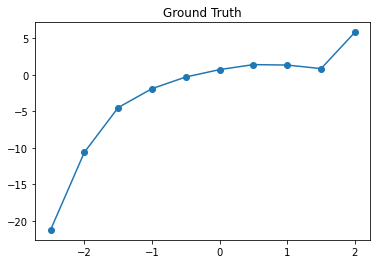

In [46]:
#2.3 question
noise = np.random.normal(0,1,10)
x = (np.arange(10)-5)/2
y = np.power(x,3) - np.power(x,2) + 1 + noise
plt.plot(x, y)
plt.scatter(x, y)
plt.title("Ground Truth")

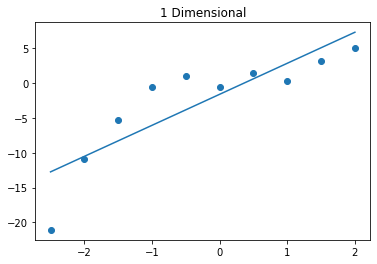

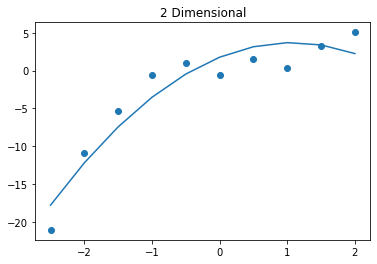

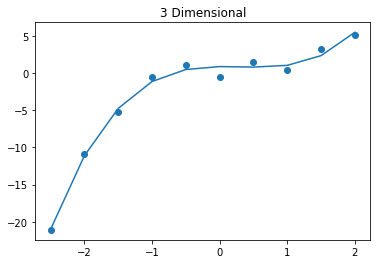

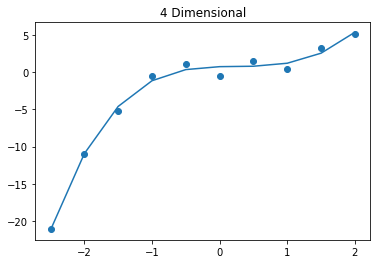

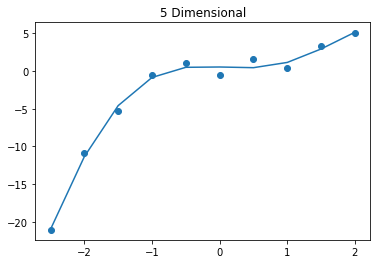

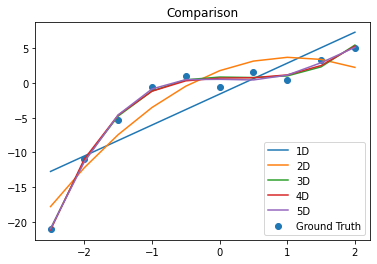

In [ ]:
pi = [1]
y_values = []
for i in range(1, 6):
    pi.insert(0, x**i)
    theta = np.polyfit(x, y, i)
    y_values.append(np.dot(pi, theta))
    plt.scatter(x,y)
    plt.plot(x,y_values[i-1])
    plt.title("{} Dimensional".format(i))
    plt.show()

fig, ax = plt.subplots()
ax.scatter(x, y, label = 'Ground Truth')
ax.plot(x, y_values[0], label='1D')
ax.plot(x, y_values[1], label='2D')
ax.plot(x, y_values[2], label='3D')
ax.plot(x, y_values[3], label='4D')
ax.plot(x, y_values[4], label='5D')
plt.title("Comparison")
ax.legend(loc='upper right', frameon=True)
leg = ax.legend();

#3. Logistic Regression

In [11]:
def sigmoid(z):
  return [1/(1 + np.exp(-h)) for h in z]

##1. Batch gradient descent

In [21]:
import timeit

In [25]:
start = timeit.timeit()
theta = np.zeros((785 , 1))
train_set_size = train_labels_26_w_dummy.shape[0]
X = train_images_26_w_dummy
Y_actual = train_labels_26_w_dummy.reshape(1000,1)
alpha = 0.5
count = 0

#Batch gradient descent
loss_grad = 1
while np.linalg.norm(loss_grad) > 0.01:
  thetaTX = np.dot(X, theta)
  h_theta = sigmoid(thetaTX)
  loss_grad = np.dot(np.transpose(X), Y_actual - h_theta)
  theta = theta + alpha*loss_grad
  count += 1

end = timeit.timeit()
theta_g = theta
print("BGD: Number of times whole training dataset is used: ", count)
print("Time taken: ", end - start)

BGD: Number of times whole training dataset is used:  173
Time taken:  0.060900035000031494


In [13]:
#Training error

thetaTX = np.dot(X, theta)
h_theta = sigmoid(thetaTX)
y_pred = [1 if val >= 0.5 else 0 for val in h_theta]
loss = 0
for i in range(train_set_size):
  if Y_actual[i] != y_pred[i]:
    loss += 1
error = (1/train_set_size)*loss
print("Training Error: {}".format(error))

#Test error
X = test_images_26_w_dummy
Y_actual = test_labels_26_log
thetaTX = np.dot(X, theta)
h_theta = sigmoid(thetaTX)
y_pred = [1 if val >= 0.5 else 0 for val in h_theta]
loss = 0
test_set_size = test_labels_26_log.shape[0]
for i in range(test_set_size):
  if Y_actual[i] != y_pred[i]:
    loss += 1
error = (1/train_set_size)*loss
print("Test Error: {}".format(error))

Training Error: 0.0
Test Error: 0.06


##2. Stochastic gradient descent

In [29]:
start2 = timeit.timeit()
theta = np.zeros((785 , 1))
train_set_size = train_labels_26_w_dummy.shape[0]
X = train_images_26_w_dummy
Y_actual = train_labels_26_w_dummy.reshape(1000,1)
X, Y_actual = shuffle(X, Y_actual)
flag = 0
alpha = 0.5
count = 0

#Stochastic gradient descent
while flag == 0:
  
  for i in range(train_set_size):
    x = X[i]
    x = x.reshape(785,1)
    thetaTX_s = np.dot(np.transpose(x), theta)
    h_theta_s = sigmoid(thetaTX_s)
    theta = theta + alpha*(Y_actual[i] - h_theta_s)*x
    

    if i % 200 == 0:
      thetaTX = np.dot(X, theta)
      h_theta = sigmoid(thetaTX)
      loss_grad = np.dot(np.transpose(X), Y_actual - h_theta)
      if np.linalg.norm(loss_grad) < 0.01:
        flag = 1
        break
  count += 1

end2 = timeit.timeit()   
theta_s = theta
print("SGD: Number of times whole training dataset is used: ", count)
print("Time taken: ", end2 - start2)

SGD: Number of times whole training dataset is used:  86
Time taken:  0.014597250000178974


In [30]:
#Training error
thetaTX = np.dot(X, theta)
h_theta = sigmoid(thetaTX)
y_pred = [1 if val >= 0.5 else 0 for val in h_theta]
loss = 0
for i in range(train_set_size):
  if Y_actual[i] != y_pred[i]:
    loss += 1
error = (1/train_set_size)*loss
print("Training Error: {}".format(error))

#Test error
X = test_images_26_w_dummy
Y_actual = test_labels_26_log
thetaTX = np.dot(X, theta)
h_theta = sigmoid(thetaTX)
y_pred = [1 if val >= 0.5 else 0 for val in h_theta]
loss = 0
test_set_size = test_labels_26_log.shape[0]
for i in range(test_set_size):
  if Y_actual[i] != y_pred[i]:
    loss += 1
error = (1/train_set_size)*loss
print("Test Error: {}".format(error))

Training Error: 0.0
Test Error: 0.056


##3. Classifiers comparison

In [31]:

#for different values of threshold
#for classifier 1: Batch gradient descent

theta = theta_g
t = np.arange(0, 1.1, 0.01)
tpr_values1 = []
fpr_values1 = []
for tr in t:

  #Test error
  X = test_images_26_w_dummy
  Y_actual = test_labels_26_log
  thetaTX = np.dot(X, theta)
  h_theta = sigmoid(thetaTX)
  y_pred = [1 if val >= tr else 0 for val in h_theta]
  true_p = 0
  false_n = 0
  false_p = 0
  true_n = 0
  test_set_size = test_labels_26_log.shape[0]
  for i in range(test_set_size):
    if Y_actual[i] == 1 and y_pred[i] == 1:
      true_p += 1
    if Y_actual[i] == 1 and y_pred[i] == 0:
      false_n += 1
    if Y_actual[i] == 0 and y_pred[i] == 1:
      false_p += 1
    if Y_actual[i] == 0 and y_pred[i] == 0:
      true_n += 1 

  true_pos_rate = true_p/(true_p + false_n)
  false_pos_rate = false_p/(false_p + true_n)
  
  tpr_values1.append(true_pos_rate)
  fpr_values1.append(false_pos_rate)



#for different values of threshold
#for classifier 2: Stochastic gradient descent

theta = theta_s
tpr_values2 = []
fpr_values2 = []
for tr in t:

  #Test error
  X = test_images_26_w_dummy
  Y_actual = test_labels_26_log
  thetaTX = np.dot(X, theta)
  h_theta = sigmoid(thetaTX)
  y_pred = [1 if val >= tr else 0 for val in h_theta]
  true_p = 0
  false_n = 0
  false_p = 0
  true_n = 0
  for i in range(test_set_size):
    if Y_actual[i] == 1 and y_pred[i] == 1:
      true_p += 1
    if Y_actual[i] == 1 and y_pred[i] == 0:
      false_n += 1
    if Y_actual[i] == 0 and y_pred[i] == 1:
      false_p += 1
    if Y_actual[i] == 0 and y_pred[i] == 0:
      true_n += 1 

  true_pos_rate = true_p/(true_p + false_n)
  false_pos_rate = false_p/(false_p + true_n)
  
  tpr_values2.append(true_pos_rate)
  fpr_values2.append(false_pos_rate)


BGD Classifier AUC:  0.971644839054231
SGD Classifier AUC:  0.984767199106666


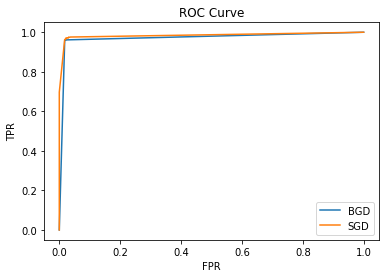

In [43]:
from sklearn.metrics import auc
fig, ax = plt.subplots()
x_val1 = fpr_values1
y_val1 = tpr_values1

x_val2 = fpr_values2
y_val2 = tpr_values2

ax.plot(x_val1, y_val1, label = 'BGD')
ax.plot(x_val2, y_val2, label = 'SGD')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
ax.legend(loc= 'upper right', frameon=True)
leg = ax.legend();


area1 = auc(x_val1, y_val1)
area2 = auc(x_val2, y_val2)

print("BGD Classifier AUC: ", area1)
print("SGD Classifier AUC: ", area2)

#4. K-fold cross validation

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import pairwise_kernels
X = train_images_26
Y = train_labels_26
# X, Y = shuffle(X, Y)
train_set_size = 900
test_set_size = 100
k_folds = 10

sigma_values = [0.2, 0.5, 1, 3, 4, 5, 10]
for val in sigma_values:

  avg_test_error = 0
  avg_train_error = 0
  X = train_images_26
  Y = train_labels_26
  for k in range(k_folds):
    s = k*100
    e = k*100 + 100

    if k == 0:
      x_train = X[e:]
      y_train = Y[e:]

    elif k == 9:
      x_train = X[:s]
      y_train = Y[:s]

    else:
      x_train = np.concatenate((X[:s], X[e:]), axis = 0)
      y_train = np.concatenate((Y[:s], Y[e:]), axis = 0)

    x_test = X[s:e]
    y_test = Y[s:e]
    
    y_train = y_train.reshape(900,1)
    # print("x train, y train", np.shape(x_train), np.shape(y_train))

    K_train = rbf_kernel(x_train, gamma=1/2/val**2) #kernel for training data
    K_train_test = rbf_kernel(x_train, x_test, gamma=1/2/val**2) #kernel for test data
    

    alpha = cp.Variable((train_set_size, 1))
    cost = 0.5*cp.quad_form( cp.multiply(alpha,y_train.reshape(train_set_size,1)) , K_train) - alpha.T * np.ones(train_set_size)
    objective = cp.Minimize(cost)

    constraints=[alpha >= 0,
             y_train @ alpha.T == 0]

    prob = cp.Problem(objective, constraints)
    prob.solve()

    alpha = alpha.value

    #Dual SVM using kernel trick
    #Calculating w* and b* from alpha
    w_dual_pix = np.dot(K_train.T, np.multiply(alpha, y_train))
    y_neg = []
    y_pos = []
    loss = 0

    for i in range(train_set_size):
      if y_train[i] == -1:
        y_neg.append(w_dual_pix[i])
      else:
        y_pos.append(w_dual_pix[i])
    
    if len(y_neg) == 0:
      b_dual = -min(y_pos)/2
    else:
      b_dual = - (max(y_neg) + min(y_pos))/2


    #Training error
    y_pred = w_dual_pix + b_dual
    y_pred = [1 if y >= 0 else -1 for y in y_pred]

    for i in range(train_set_size):
      if y_train[i] != y_pred[i]:
        loss += 1

    train_error = (1/train_set_size)*loss
    train_accuracy = (1-train_error)*100
    avg_train_error += train_error
    # print("train", avg_train_error)
    

    #Test error
    #Calculating w* and b* from alpha

    w_dual_pix = np.dot(K_train_test.T, alpha*y_train)
    y_val = y_test
    y_neg = []
    y_pos = []
    loss = 0

    #Test error
    y_pred = w_dual_pix + b_dual
    y_pred = [1 if y >= 0 else -1 for y in y_pred]

    for i in range(test_set_size):
      if y_val[i] != y_pred[i]:
        loss += 1

    test_error = (1/test_set_size)*loss
    test_accuracy = (1-test_error)*100

    avg_test_error += test_error
    # print("test", avg_test_error)

  train_error_val = avg_train_error/(k_folds - 1)
  test_error_val = avg_test_error/(k_folds - 1)
  print("Sigma: {}, Training Error: {}, Test Error: {}".format(val, train_error_val, test_error_val))

Sigma: 0.2, Training Error: 0.0, Test Error: 0.5655555555555556
Sigma: 0.5, Training Error: 0.0, Test Error: 0.5299999999999999
Sigma: 1, Training Error: 0.0, Test Error: 0.035555555555555556
Sigma: 3, Training Error: 0.01790123456790124, Test Error: 0.06333333333333334
Sigma: 4, Training Error: 0.04012345679012346, Test Error: 0.05555555555555555
Sigma: 5, Training Error: 0.047654320987654326, Test Error: 0.05555555555555555
Sigma: 10, Training Error: 0.060740740740740734, Test Error: 0.06333333333333334
